### Setup

In [22]:
# core
import pydicom, numpy as np, matplotlib.pyplot as plt
from pydicom import dcmread

# image processing
from skimage.filters import threshold_otsu
from scipy.signal import butter, filtfilt, medfilt
import cv2  # OpenCV
from matplotlib.widgets import RectangleSelector

# handy utils
from dataclasses import dataclass


### 1. Load DICOM and extract cine frames

image size: 960 x 1280


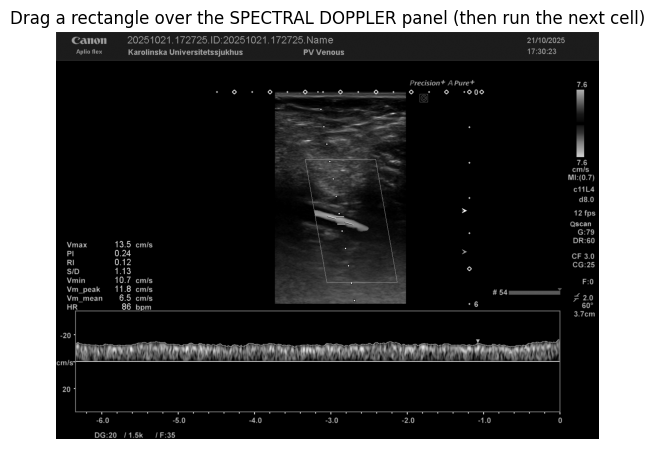

In [24]:
ds = dcmread("../A0000")

img = ds.pixel_array
if img.ndim == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)
H, W = img.shape
print(f"image size: {H} x {W}")

# 3) interactive ROI picker
roi_coords = {}   # will get populated by the callback

fig, ax = plt.subplots(figsize=(7,6))
ax.imshow(img, cmap='gray')
ax.set_title("Drag a rectangle over the SPECTRAL DOPPLER panel (then run the next cell)")
ax.axis('off')

def onselect(eclick, erelease):
    # Ensure top-left / bottom-right ordering
    x0, y0 = int(min(eclick.xdata,  erelease.xdata)), int(min(eclick.ydata,  erelease.ydata))
    x1, y1 = int(max(eclick.xdata,  erelease.xdata)), int(max(eclick.ydata,  erelease.ydata))
    roi_coords['x0'], roi_coords['y0'], roi_coords['x1'], roi_coords['y1'] = x0, y0, x1, y1
    print("ROI set:", roi_coords)

rs = RectangleSelector(ax, onselect,
                       useblit=False, button=[1],  # left-click drag
                       interactive=True, minspanx=10, minspany=10)
plt.show()

### 2. Choose / detect the spectral panel ROI
Many ultrasound clips include B-mode + spectral + text overlays. Start simple: manual ROI once, then reuse for all frames.

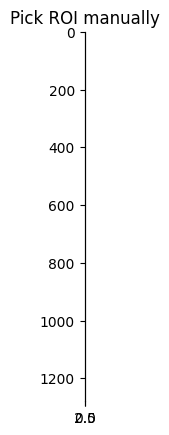

In [8]:
# show a mid frame and draw a rectangle to pick the spectrogram
mid = frames[len(frames)//2].astype(np.float32)
plt.imshow(mid, cmap='gray'); plt.title("Pick ROI manually"); plt.show()

# (Option A): enter ROI bounds you observed, e.g. y0:y1, x0:x1
y0,y1,x0,x1 = 200, 700, 100, 1100
spec = frames[:, y0:y1, x0:x1]


### 3. Calibrate pixels → time (s) and velocity (cm/s)
You need two scale factors:

Horizontal (px → s): if dt is known from DICOM you’re done; otherwise use the on-screen sweep speed grid (e.g., “2 s” span) and click two vertical gridlines.

Vertical (px → cm/s): click two tick labels (e.g., 0 and 100 cm/s) or use a known vertical scale bar.

Minimal manual approach:

In [9]:
@dataclass
class Calib:
    px_per_s: float   # horizontal pixels per second
    px_per_cms: float # vertical pixels per cm/s
    v0_offset_px: int # pixel row for 0 cm/s (from bottom/top reference)

# Example after measuring on the image (replace with your clicks)
px_span_seconds = 600  # pixels between two time gridlines
seconds_span = 2.0
px_per_s = px_span_seconds / seconds_span

px_span_vel = 480     # pixels between 0 and +120 cm/s tick
vel_span = 120.0
px_per_cms = px_span_vel / vel_span

v0_offset_px = 350    # row index in ROI that corresponds to 0 cm/s (depends on UI)
cal = Calib(px_per_s, px_per_cms, v0_offset_px)


### Preprocess each frame (crop → normalize)

In [10]:
spec = spec.astype(np.float32)
# Normalize to 0..1 per frame (simple; improve later if needed)
spec_n = (spec - spec.min(axis=(1,2), keepdims=True)) / (spec.max(axis=(1,2), keepdims=True) - spec.min(axis=(1,2), keepdims=True) + 1e-6)


ValueError: zero-size array to reduction operation minimum which has no identity

### Otsu threshold + grid search and 2D median despeckle
Wadehn & Heldt use Otsu then try nearby thresholds, with a 2D median filter roughly 0.03 s × 5 cm/s (convert to pixels via calibration)

In [11]:
def binarize_frame(im, thr):
    return (im >= thr).astype(np.uint8)

# Compute a global Otsu on a representative frame region:
ref = spec_n[len(spec_n)//2]
thr_otsu = threshold_otsu(ref)

# Grid around Otsu (tweak multipliers as needed)
thr_grid = [0.9*thr_otsu, 0.95*thr_otsu, thr_otsu, 1.05*thr_otsu, 1.1*thr_otsu]

# 2D median kernel in pixels from physical units:
kx = max(1, int(0.03 * cal.px_per_s))         # ~0.03 s horizontally
ky = max(1, int(5.0 * cal.px_per_cms))        # ~5 cm/s vertically
if kx % 2 == 0: kx += 1
if ky % 2 == 0: ky += 1
kernel = (ky, kx)


NameError: name 'spec_n' is not defined

### Envelope tracing (column-wise maximum after despeckle)
For each threshold, despeckle, then for each time column take the highest “on” pixel as the maximal velocity. Finally, pick the best candidate by a beat-quality score (next step). This follows their column-wise envelope extraction. 

In [12]:
def trace_envelope(binary_stack):
    # binary_stack: (T, H, W)
    T,H,W = binary_stack.shape
    env_px = np.zeros(W, dtype=np.float32)
    # Use median across time to stabilize column occupancy
    mask = binary_stack.max(axis=0)  # any time point lights a pixel
    for x in range(W):
        col = mask[:, x]
        ys = np.where(col>0)[0]
        env_px[x] = ys.min() if len(ys)>0 else np.nan  # topmost 'on' pixel (row index small=top)
    return env_px  # in pixels from top

def px_to_velocity(env_px):
    # Convert row index to cm/s given 0 cm/s offset; assume positive flow upwards
    # If your display is inverted, adapt sign.
    dy_px = (cal.v0_offset_px - env_px)  # px above 0-line
    return dy_px / cal.px_per_cms


### 7. Pick the best envelope via beat-quality index

In [13]:
def simple_beat_onsets(v, fs, min_rr=0.4):
    # crude onset detector on the envelope derivative
    dv = np.gradient(v)
    thr = np.percentile(dv, 80)
    idx = np.where(dv>thr)[0]
    # thin by refractory
    onsets = []
    last = -1e9
    gap = int(min_rr*fs)
    for i in idx:
        if i-last > gap:
            onsets.append(i); last = i
    return np.array(onsets, dtype=int)

def beat_quality(v, fs):
    on = simple_beat_onsets(v, fs)
    beats = [v[on[i]:on[i+1]] for i in range(len(on)-1)]
    L = max(len(b) for b in beats)
    # zero-pad and build template (median)
    pad = [np.pad(b, (0, L-len(b))) for b in beats]
    M = np.median(np.vstack(pad), axis=0)
    # compare each beat to template on first 75%
    L75 = int(0.75*L)
    mse = [np.mean((b[:L75] - M[:L75])**2) / (np.mean(M[:L75]**2)+1e-6) for b in pad]
    # signal quality index (0–100%) as in the paper’s spirit: 1 - normalized MSE
    sqi = [max(0.0, 1.0 - m)*100 for m in mse]
    return np.array(sqi), on

def choose_best_candidate(v_candidates, fs):
    # pick candidate with smallest artifact index (beats with SQI < 30% flagged)
    best = None; best_art = 1e9
    for v in v_candidates:
        sqi, on = beat_quality(v, fs)
        art = np.mean(sqi < 30.0)  # artifact index
        if art < best_art:
            best = v; best_art = art
    return best


### 8. Post-filtering (median + low-pass)
Wadehn & Heldt used a 4th-order Butterworth (fc≈16 Hz at their sampling) and a short 1D median to clean spikes. You’ll adapt fc to your envelope sampling rate (fs = px_per_s).

In [14]:
def smooth_envelope(v, fs):
    v_med = medfilt(v, kernel_size=3)  # ~14 ms in their setup; OK to keep 3
    # low-pass at e.g. 12–16 Hz (envelope changes slower than spectrogram sampling)
    fc = min(16.0, 0.4*fs)            # cap at 0.4*Nyquist
    b,a = butter(4, fc/(fs/2), btype='low')
    return filtfilt(b,a, v_med)

# Build candidate envelopes over threshold grid
v_candidates = []
for thr in thr_grid:
    # binarize every frame, median-filter each, OR median over time then filter (choose 1)
    # simple approach: median over time -> filter once
    im = np.median(spec_n, axis=0)
    _, im_f = cv2.threshold(im, thr, 1, cv2.THRESH_BINARY)
    im_f = cv2.medianBlur((im_f*255).astype(np.uint8), kx|1)  # rough despeckle fallback
    env_px = trace_envelope(np.repeat(im_f[None,...]>0, 1, axis=0))
    v = px_to_velocity(env_px)
    v_candidates.append(v)

fs_env = cal.px_per_s  # “samples per second” along columns
v_best = choose_best_candidate(v_candidates, fs_env)
v_smooth = smooth_envelope(v_best, fs_env)


NameError: name 'thr_grid' is not defined

### 9. Beat metrics and windowed features

In [15]:
def beat_metrics(v, fs, onsets):
    beats=[]
    for i in range(len(onsets)-1):
        seg = v[onsets[i]:onsets[i+1]]
        PSV = np.nanmax(seg)
        EDV = np.nanmin(seg[-int(0.2*len(seg)):])  # crude: min in last 20% of beat
        MFV = np.nanmean(seg)
        PI  = (PSV - EDV) / (MFV + 1e-6)
        RI  = (PSV - EDV) / (PSV + 1e-6)
        beats.append(dict(PSV=PSV, EDV=EDV, MFV=MFV, PI=PI, RI=RI))
    return beats

sqi, on = beat_quality(v_smooth, fs_env)
bm = beat_metrics(v_smooth, fs_env, on)

# Windowed summary (e.g., 20 s)
win = int(20*fs_env)
features=[]
for start in range(0, len(v_smooth)-win, win):
    end = start+win
    # beats fully inside window
    inside = (on>=start) & (on<end)
    if inside.sum()>=3:
        idx = np.where(inside)[0]
        vals = [bm[i] for i in idx if sqi[i] >= 30]  # keep good beats
        if len(vals)>=3:
            features.append({
                "t0_s": start/fs_env,
                "PSV_mean": np.mean([d["PSV"] for d in vals]),
                "EDV_mean": np.mean([d["EDV"] for d in vals]),
                "MFV_mean": np.mean([d["MFV"] for d in vals]),
                "PI_mean":  np.mean([d["PI"]  for d in vals]),
                "RI_mean":  np.mean([d["RI"]  for d in vals]),
                "artifact_pct": 100*(1 - len(vals)/len(idx))
            })


NameError: name 'v_smooth' is not defined